In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams

https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755

1) Visualizar la distribución de la data

En un diagrama de caja, presentado por John Tukey en 1970, los datos se dividen en cuartiles. Por lo general, muestra un cuadro rectangular que representa el 25% -75% de las observaciones de una muestra, extendido por los llamados bigotes que alcanzan la entrada de datos mínima y máxima. Las observaciones que se muestran fuera de los bigotes son valores atípicos (se explican con más detalle a continuación).



In [2]:
#Load libraries
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

#Load data
X, y = load_boston(return_X_y=True)

#Create data frame
boston = load_boston()
columns = boston.feature_names
df = pd.DataFrame(X, columns = columns)

In [3]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [4]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


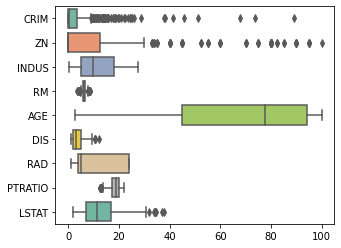

In [115]:

df_1 = df[['TAX', 'B']]
df_2 = df[['CRIM', 'ZN', 'INDUS', 'RM', 'AGE', 'DIS', 'RAD', 'PTRATIO','LSTAT']]
df_3 = df[['CHAS', 'NOX']]

ax = sns.boxplot(data=df_2, orient="h", palette="Set2")

Text(0.5, 0, 'Crime rate per capita')

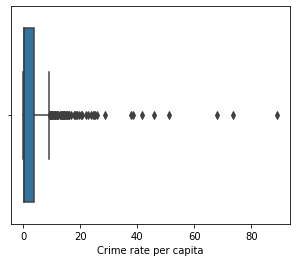

In [116]:

ax = sns.boxplot(x=df["CRIM"])
ax.set_xlabel('Crime rate per capita')

In [117]:
#Tukey's method
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss

In [118]:
probable_outliers_tm, possible_outliers_tm = tukeys_method(df, "CRIM")
print(probable_outliers_tm)

[374, 375, 376, 378, 379, 380, 381, 384, 385, 386, 387, 398, 400, 403, 404, 405, 406, 410, 412, 413, 414, 415, 417, 418, 425, 427, 437, 440, 468, 477]


In [119]:
print(possible_outliers_tm)

[367, 371, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 384, 385, 386, 387, 388, 392, 394, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 422, 425, 426, 427, 429, 431, 434, 435, 436, 437, 438, 439, 440, 441, 443, 444, 445, 447, 448, 454, 468, 469, 477, 478, 479]


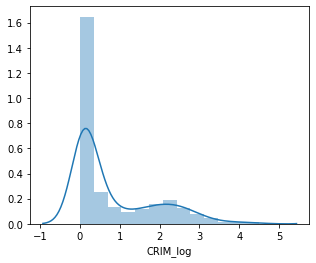

In [120]:

#Transform 'CRIM' to log 
log_CRIM = np.log(df['CRIM'])
df['CRIM_man'] = df['CRIM']+1
log_CRIM = np.log(df['CRIM_man'])
df['CRIM_log'] = log_CRIM

#Plot
sns.distplot(df['CRIM_log'])

In [121]:
#Calculate probable and possible outliers using log-iq method
probable_outliers_logiq, possible_outliers_logiq = tukeys_method(df, 'CRIM_log')
print(probable_outliers_logiq)
print(possible_outliers_logiq)

[]
[380, 404, 405, 410, 414, 418]


----

----

https://www.youtube.com/watch?v=A3gClkblXK8&ab_channel=codebasics

In [5]:
df1 = pd.read_csv('https://raw.githubusercontent.com/codebasics/py/master/ML/FeatureEngineering/3_outlier_IQR/heights.csv', sep=',')
df2 = pd.read_csv('https://raw.githubusercontent.com/codebasics/py/master/ML/FeatureEngineering/3_outlier_IQR/heights.csv', sep=',')

In [6]:
df1

,name,height
0,mohan,1.2
1,maria,2.3
2,sakib,4.9
3,tao,5.1
4,virat,5.2
5,khusbu,5.4
6,dmitry,5.5
7,selena,5.5
8,john,5.6
9,imran,5.6


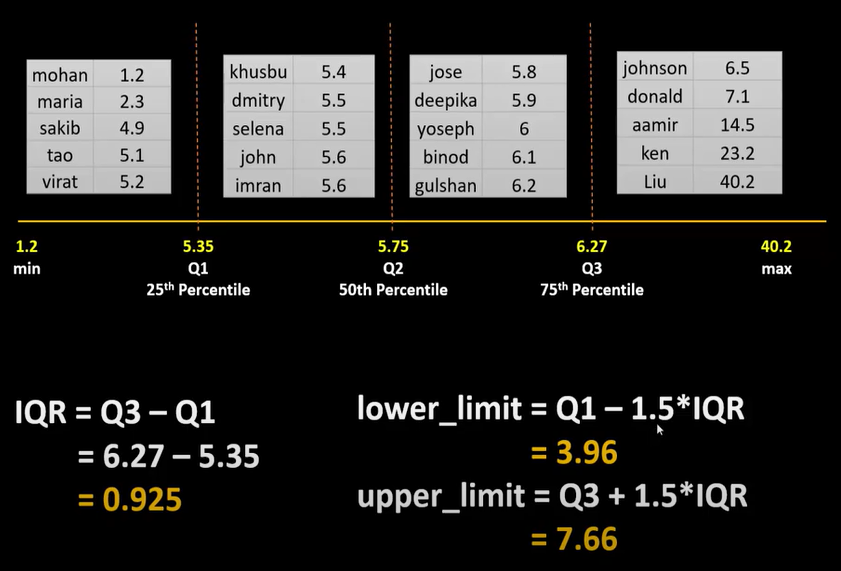

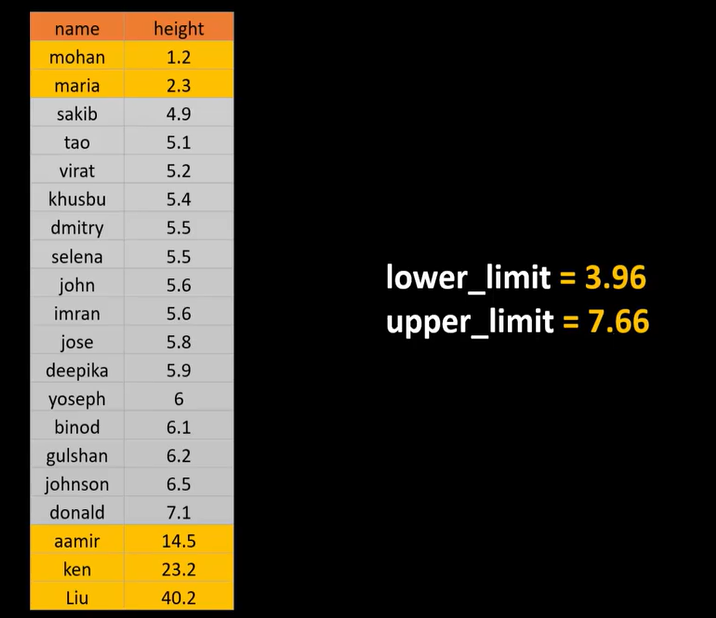

In [7]:
df1.describe()

,height
count,20.000000
mean,8.390000
std,8.782812
min,1.200000
25%,5.350000
50%,5.700000
75%,6.275000
max,40.200000


In [8]:
is_canceled - CURTOSIS:  -1.7 IQR = 1.0  (deberia aparecer)
lead_time - CURTOSIS:  1.7 IQR = 142 (deberia aparecer)
arrival_date_week_number - CURTOSIS:  -1.0 IQR: 22.0 (deberia aparecer) - APARECE
arrival_date_day_of_month - CURTOSIS:  -1.2 IQR: 15.0 (deberia aparecer)
agent - CURTOSIS:  0.0 IQR: 220.0 (deberia aparecer) - APARECE
company - CURTOSIS:  -0.5 IQR: 208.0 (deberia aparecer)
total_of_special_requests - CURTOSIS:  1.5 IQR: 1.0 (deberia aparecer)

SyntaxError: invalid syntax (<ipython-input-8-99e1ac109a73>, line 1)

In [9]:
Q1 = df1.height.quantile(0.25)
Q3 = df1.height.quantile(0.75)
Q1,Q3

(5.3500000000000005, 6.275)

In [10]:
IQR = Q3 - Q1
IQR

0.9249999999999998

In [11]:
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
lower_limit, upper_limit

(3.962500000000001, 7.6625)

In [12]:
#Aquí se muestran los outliers del dataset basados en tukey o IQR
df1[(df1.height < lower_limit)|(df1.height > upper_limit)]

,name,height
0,mohan,1.2
1,maria,2.3
17,aamir,14.5
18,ken,23.2
19,Liu,40.2


In [13]:
#Dataframe sin los outliers detectados por el método de IQR
df_no_outliers = df1[(df1.height > lower_limit) & (df1.height < upper_limit)]
df_no_outliers

,name,height
2,sakib,4.9
3,tao,5.1
4,virat,5.2
5,khusbu,5.4
6,dmitry,5.5
7,selena,5.5
8,john,5.6
9,imran,5.6
10,jose,5.8
11,deepika,5.9


-------------

In [14]:
### ESTE CODIGO NO FUNCIONA, PERO PODRÍA SERVIR PARA CREAR UNA FUNCION DE TUKEY PROPIA
import numpy as np
from collections import Counter


def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

In [155]:
# detect outliers from list of features
lof = ['height']
# params dataset, number of outliers for rejection, list of features
Outliers_to_drop = detect_outliers(df2, 1, lof)
Outliers_to_drop

[]

In [148]:
df2.loc[8]=[ 'Example', 100]

In [153]:
df2 = df2.sort_values('height')

In [15]:
df2

,name,height
0,mohan,1.2
1,maria,2.3
2,sakib,4.9
3,tao,5.1
4,virat,5.2
5,khusbu,5.4
6,dmitry,5.5
7,selena,5.5
8,john,5.6
9,imran,5.6


In [156]:
Q1_1 = df2.height.quantile(0.25)
Q3_3 = df2.height.quantile(0.75)
Q1_1,Q3_3

(5.3500000000000005, 6.65)

In [157]:
IQR_1 = Q3_3 - Q1_1
IQR_1

1.2999999999999998

In [159]:
lower_limit_1 = Q1_1 - 1.5*IQR_1
upper_limit_1 = Q3_3 + 1.5*IQR_1
lower_limit_1, upper_limit_1

(3.400000000000001, 8.6)

In [161]:
#Aquí se muestran los outliers del dataset basados en tukey o IQR
df2[(df2.height < lower_limit_1)|(df2.height > upper_limit_1)]

,name,height
0,mohan,1.2
1,maria,2.3
17,aamir,14.5
18,ken,23.2
19,Liu,40.2
8,Example,100.0


In [162]:
#Dataframe sin los outliers detectados por el método de IQR
df_no_outliers_1 = df2[(df2.height > lower_limit_1) & (df2.height < upper_limit_1)]
df_no_outliers_1

,name,height
2,sakib,4.9
3,tao,5.1
4,virat,5.2
5,khusbu,5.4
6,dmitry,5.5
7,selena,5.5
9,imran,5.6
10,jose,5.8
11,deepika,5.9
12,yoseph,6.0
